In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

In [194]:
movies = 'data/ml-latest/movies.csv'
ratings = 'data/ml-latest/ratings.csv'
tags = 'data/ml-latest/tags.csv'

df_movies = pd.read_csv(movies, usecols=['movieId', 'title'], dtype={'movieId':'int32', 'title':'str'})
df_ratings = pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId': 'int32', 'rating':'float32'})
df_tags = pd.read_csv(tags, usecols=['userId', 'movieId', 'tag', 'timestamp'], dtype={'userId':'int32', 'movieId': 'int32', 'tag':'str', 'timestamp': 'int32'})

### a) EDA

In [127]:
df_tags.head(10)

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746
5,14,58559,Atmospheric,1311530439
6,14,58559,Batman,1311530391
7,14,58559,comic book,1311530398
8,14,58559,dark,1311530428
9,14,58559,Heath Ledger,1311530404


In [ ]:
df_movies.info()
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86537 entries, 0 to 86536
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  86537 non-null  int32 
 1   title    86537 non-null  object
dtypes: int32(1), object(1)
memory usage: 1014.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 387.2 MB


In [ ]:
df_movies.shape

(86537, 2)

In [ ]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
df_ratings.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0
5,1,381,3.5
6,1,596,4.0
7,1,1036,5.0
8,1,1049,3.0
9,1,1066,4.0


In [ ]:
num_movies = df_movies.shape
num_ratings = df_ratings.shape
print(f'\nTotal number of movies and columns: {num_movies}')
print(f'Total number of ratings and columns: {num_ratings}')


Total number of movies and columns: (86537, 2)
Total number of ratings and columns: (33832162, 3)


### b) De 10 filmer med flest ratings

In [205]:
# Beräknar antalet betyg per film
ratings_count = df_ratings['movieId'].value_counts().reset_index()
ratings_count.columns = ['movieId', 'num_ratings']

# Sorterar filmerna efter antalet betyg
sorted_movies = ratings_count.sort_values(by='num_ratings', ascending=False)

# De 10 filmer med flest betyg
top_10_movies = sorted_movies.head(10)

# Slå ihop top_10_movies med df_movies för att få titlarna
top_10_movie_title = pd.merge(top_10_movies, df_movies, on='movieId')

print('Top 10 Movies with Most Ratings')
print(top_10_movie_title[['movieId', 'title', 'num_ratings']].to_string(index=False))


Top 10 Movies with Most Ratings
 movieId                                                 title  num_ratings
     318                      Shawshank Redemption, The (1994)       122296
     356                                   Forrest Gump (1994)       113581
     296                                   Pulp Fiction (1994)       108756
    2571                                    Matrix, The (1999)       107056
     593                      Silence of the Lambs, The (1991)       101802
     260             Star Wars: Episode IV - A New Hope (1977)        97202
    2959                                     Fight Club (1999)        86207
     527                               Schindler's List (1993)        84232
     480                                  Jurassic Park (1993)        83026
    1196 Star Wars: Episode V - The Empire Strikes Back (1980)        80200


### c) Genomsnittliga ratingen för de 10 filmerna med flest ratings

In [218]:
# 10 filmer med flest betyg
top_10_movies = df_ratings['movieId'].value_counts().head(10).index

# Filtrerar betyg för de 10 filmer med flest betyg
ratings_top_10 = df_ratings[df_ratings['movieId'].isin(top_10_movies)]

# Beräknar genomsnittligt betyg för varje film
average_ratings_top_10 = ratings_top_10.groupby('movieId')['rating'].mean().reset_index(name='avg_rating')

# Slå ihop top_10_movies med df_movies för att få titlarna
top_10_movie_title = pd.merge(average_ratings_top_10, df_movies, on='movieId')

# Sortera top_10_movie_title efter avg_rating i avtagande ordning
top_10_movie_title_sorted = top_10_movie_title.sort_values(by='avg_rating', ascending=False)

print('Average Ratings for Top 10 Movies')
print(top_10_movie_title_sorted[['movieId', 'title', 'avg_rating']].to_string(index=False))

Average Ratings for Top 10 Movies
 movieId                                                 title  avg_rating
     318                      Shawshank Redemption, The (1994)    4.416792
     527                               Schindler's List (1993)    4.242337
    2959                                     Fight Club (1999)    4.236019
     296                                   Pulp Fiction (1994)    4.191778
    2571                                    Matrix, The (1999)    4.160631
     593                      Silence of the Lambs, The (1991)    4.150287
    1196 Star Wars: Episode V - The Empire Strikes Back (1980)    4.118030
     260             Star Wars: Episode IV - A New Hope (1977)    4.092401
     356                                   Forrest Gump (1994)    4.068189
     480                                  Jurassic Park (1993)    3.689013


### d) Plot över årtal och antalet filmer

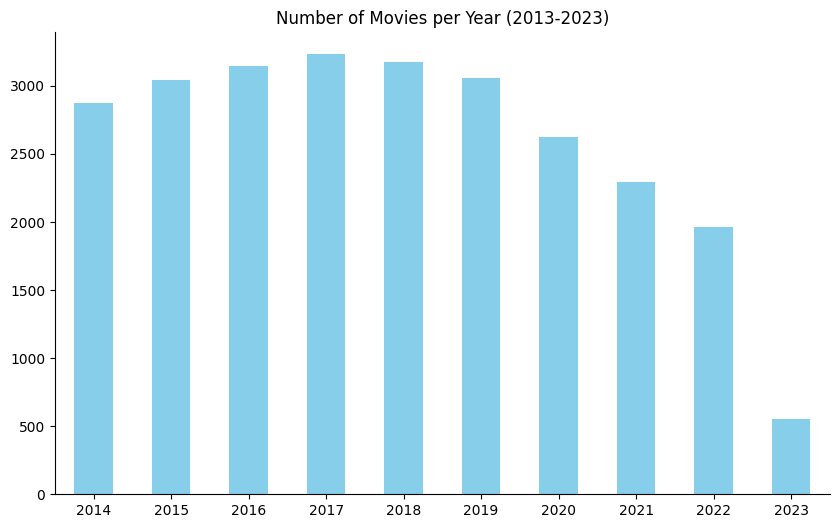

In [ ]:
# Extraherar år från titeln: (r'\((\d{4})\)') tar 4 siffror inom parentes, i detta fall år
df_movies['year'] = df_movies['title'].str.extract(r'\((\d{4})\)')

# Konverterar året till numeriskt format
df_movies['year'] = df_movies['year'].apply(lambda x: pd.to_numeric(x, errors='coerce')).astype('Int32')

# Filtrerar ut filmer mellan 2014 och 2023
df_movies_filtered = df_movies[(df_movies['year'] >= 2014) & (df_movies['year'] <= 2023)]

# Grupperar och beräknar antalet filmer per år
movies_per_year_filtered = df_movies_filtered.groupby('year').size()

# Sorterar resultatet i fallande ordning och tar de sista 10 åren
movies_per_year_filtered_sorted = movies_per_year_filtered.sort_index(ascending=True).head(11)

fig, ax = plt.subplots(figsize=(10, 6))
movies_per_year_filtered_sorted.plot(kind='bar', color='skyblue', ax=ax)
ax.set_title('Number of Movies per Year (2013-2023)')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


### e) Plot över antalet ratings mot movieId

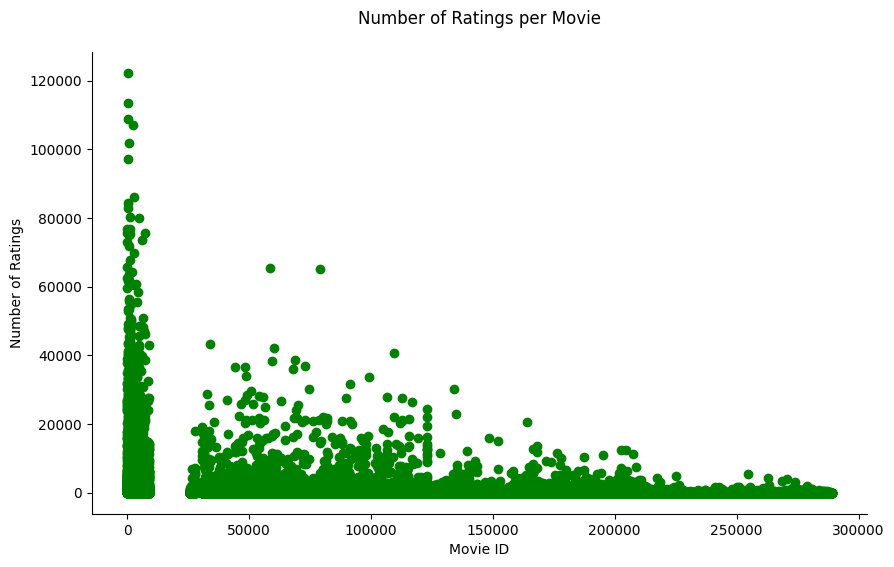

In [157]:
# Antalet betyg per film
ratings_per_movie = df_ratings.groupby('movieId').size()

fig, ax = plt.subplots(figsize=(10, 6))
# Plottar antalet betyg mot movieId
ax.plot(ratings_per_movie.index, ratings_per_movie.values, marker='o', linestyle='', color='green')
ax.set_title('Number of Ratings per Movie', pad=20)
ax.set_xlabel('Movie ID')
ax.set_ylabel('Number of Ratings')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


### f) Genomsnittliga ratings för de top 10 filmerna med flest ratings

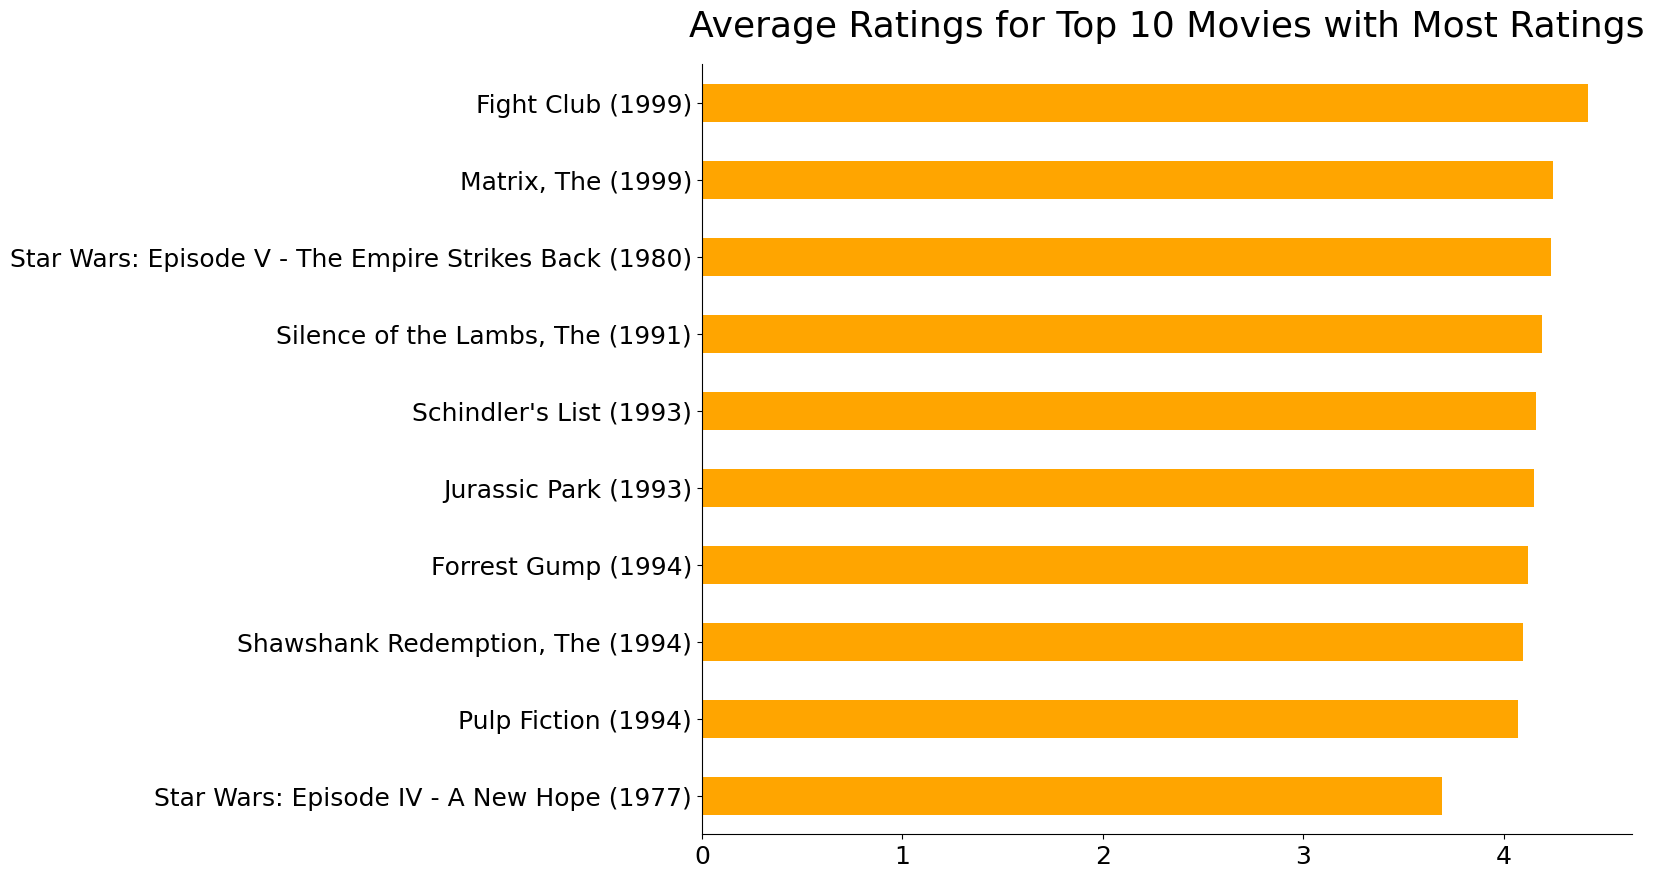

In [ ]:
# 10 filmer med flest betyg
top_10_movies = df_ratings['movieId'].value_counts().head(10).index

# Filtrerar betyg för de 10 filmer med flest betyg
ratings_top_10 = df_ratings[df_ratings['movieId'].isin(top_10_movies)]

# Beräknar genomsnittligt betyg för varje film
average_ratings_top_10 = ratings_top_10.groupby('movieId')['rating'].mean()

# Hämtar titlar för de 10 filmer med flest betyg
movie_titles = df_movies[df_movies['movieId'].isin(top_10_movies)].set_index('movieId')['title']

# Sortera betygen i stigande ordning
average_ratings_top_10_sorted = average_ratings_top_10.sort_values(ascending=True)

# Använder filmernas titlar som index för average_ratings_top_10_sorted
average_ratings_top_10_sorted.index = movie_titles

# Plottar med liggande staplar
fig, ax = plt.subplots(figsize=(12, 10))
average_ratings_top_10_sorted.plot(kind='barh', color='orange')
ax.set_title('Average Ratings for Top 10 Movies with Most Ratings', pad=20, font=dict(size=26), loc='center')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()


## 1.2

In [163]:
from scipy.sparse import csr_matrix

# Filtrerar ut användare och filmer baserat på antal betyg som getts och mottagits
min_user_ratings = 100
min_movie_ratings = 1000

# Antalet betyg per användare och film
user_counts = df_ratings['userId'].value_counts()
movie_counts = df_ratings['movieId'].value_counts()

# Filtrerar användare och filmer baserat på antal betyg
filtered_users = user_counts[user_counts >= min_user_ratings].index
filtered_movies = movie_counts[movie_counts >= min_movie_ratings].index

# Filtrerar DataFramen för att bara behålla betyg från dessa användare och filmer
df_filtered = df_ratings[(df_ratings['userId'].isin(filtered_users)) & (df_ratings['movieId'].isin(filtered_movies))]

# Betyg baserat på användare och filmer
min_rating = 3
max_rating = 5
df_filtered = df_filtered[(df_filtered['rating'] >= min_rating) & (df_filtered['rating'] <= max_rating)]

# Använder alternativa betygsformat ( i detta fall binära betyg)
df_filtered['binary_rating'] = (df_filtered['rating'] > 3).astype(int)

# Skapar en gles matris från den filtrerade DataFramen
sparse_matrix = csr_matrix((df_filtered['rating'], (df_filtered['movieId'], df_filtered['userId'])))

# Resultatet blir en gles matris där varje rad representerar en film och varje kolumn representerar en användare,
# och varje cell innehåller betyget som användaren har gett filmen


## 1.3

In [159]:
model_knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=2)

In [160]:
model_knn.fit(sparse_matrix) # Här använder vi redan .fit

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=2)

In [175]:
# Först, fyll NaN-värden med ''ND'' sträng i kolumnen 'tag'
df_tags_filled = df_tags.fillna({'tag': 'ND'})

# # Filtrera filmer som tillhör en specifik genre
# desired_genre = "Action"
# df_movies_genre = df_tags_filled[df_tags_filled['tag'].str.contains(desired_genre, case=False)]

# Skapa en ny DataFrame för betyg för filmer som tillhör den specifika genren
df_filtered_genre = df_ratings[df_ratings['movieId'].isin(df_movies['movieId'])]

# Träna modellen och göra rekommendationer som vanligt
model_knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=2)
model_knn.fit(df_filtered_genre)  # Träna modellen med data från den specifika genren

def recommender_genre(movie_name, model, n_recommendations):
    match = process.extractOne(movie_name, df_tags["tag"])
    if match is not None:
        idx = match[0]
        print("Movie Selected: ", df_tags["tag"].iloc[idx], "Index: ", idx)
        print("Searching for recommendations....")
        distances, indices = model.kneighbors(sparse_matrix[idx].reshape(1, -1), n_neighbors=n_recommendations)
        for i in indices:
            if i != idx and 0 <= i < len(df_tags):  # Kontroll för att undvika ogiltiga index
                print(df_tags["tag"].iloc[i])
            else:
                print("Invalid index:", i)
    else:
        print("Movie not found:", movie_name)

# Använd funktionen för att göra rekommendationer för en specifik film inom den valda genren
recommender_genre('toy story', model_knn, 20)


TypeError: Cannot index by location index with a non-integer key

In [164]:
# Skapar en gles matris från den filtrerade DataFramen för den specifika genren
sparse_matrix_genre = csr_matrix((df_filtered_genre['rating'], (df_filtered_genre['movieId'], df_filtered_genre['userId'])))

# Träna modellen och göra rekommendationer som vanligt
model_knn_genre = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=2)
model_knn_genre.fit(sparse_matrix_genre)  # Träna modellen med data från den specifika genren

def recommender_genre(movie_name, model, n_recommendations):
    match = process.extractOne(movie_name, df_movies_genre["tag"])
    if match is not None:
        idx = match[2]
        if 0 <= idx < len(df_movies_genre):
            print("Movie Selected: ", df_movies_genre["tag"].iloc[idx], "Index: ", idx)
            print("Searching for recommendations....")
            distances, indices = model.kneighbors(sparse_matrix[idx].reshape(1, -1), n_neighbors=n_recommendations)
            for i in indices:
                if i != idx and 0 <= i < len(df_movies_genre):  # Kontroll för att undvika ogiltiga index
                    print(df_movies_genre["tag"].iloc[i])
                else:
                    print("Invalid index:", i)
        else:
            print("Invalid index:", idx)
    else:
        print("Movie not found:", movie_name)


# Använd funktionen för att göra rekommendationer för en specifik film inom den valda genren
recommender_genre("fight club", model_knn_genre, 20)


Invalid index: 1047548
